In [ ]:
# N-Body Gravitational Simulation  
# **Computational Physics Portfolio Project**  
# Physics student freelance demo: Newtonian gravity for multiple bodies  
# Uses vectorized NumPy + SciPy ODE integration + Matplotlib animation  
# Example: Sun + Earth-like planets in 2D

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [2]:
# Gravitational constant (scaled for nicer numbers – real G=6.67430e-11, but we use AU/year units often)
G = 4 * np.pi**2   # in units where AU=1, year=1, solar mass=1 → Earth orbit period=1 year

def nbody_deriv(state, t, G, masses):
    """
    state: flattened array [x1,y1,vx1,vy1, x2,y2,vx2,vy2, ...]
    returns derivatives: [vx,vy, ax,ay, ...]
    """
    n = len(masses)
    positions = state[:2*n].reshape((n, 2))   # (n bodies, 2 coords)
    velocities = state[2*n:].reshape((n, 2))
    
    accelerations = np.zeros_like(positions)
    
    for i in range(n):
        for j in range(n):
            if i == j: continue
            r_vec = positions[j] - positions[i]
            r = np.linalg.norm(r_vec)
            if r < 1e-10: continue  # avoid division by zero
            accelerations[i] += G * masses[j] * r_vec / r**3
    
    return np.concatenate((velocities.flatten(), accelerations.flatten()))

In [3]:
# Bodies: 0=Sun, 1-4=planets
masses = np.array([1.0, 3e-6, 3e-6, 3e-6, 3e-6])  # Sun=1, planets ~ Earth mass

n_bodies = len(masses)

# Initial positions (x,y) in AU-like units, velocities for near-circular orbits
positions_init = np.array([
    [0, 0],           # Sun at center
    [1.0, 0],         # Planet 1 at 1 AU
    [1.5, 0],         # Planet 2
    [2.0, 0.2],       # Planet 3 (slight offset for interest)
    [0.8, -0.5]       # Planet 4
])

# Initial velocities
velocities_init = np.array([
    [0, 0],                                 # Sun almost still
    [0, np.sqrt(G * masses[0] / 1.0)],      # Planet 1
    [0, np.sqrt(G * masses[0] / 1.5)],      
    [0, np.sqrt(G * masses[0] / 2.0)],      
    [np.sqrt(G * masses[0] / np.linalg.norm(positions_init[4])), 0]  # approximate
])

# Flatten into state vector
y0 = np.concatenate((positions_init.flatten(), velocities_init.flatten()))

# Time array: simulate ~5 years
t = np.linspace(0, 5, 2000)   # adjust frames for smoother animation

In [4]:
sol = odeint(nbody_deriv, y0, t, args=(G, masses))

# Reshape solution: (time, bodies*4) → (time, bodies, 4) → extract positions
positions_over_time = sol[:, :2*n_bodies].reshape(-1, n_bodies, 2)  # (t, n, 2)

print("✅ N-body simulation complete!")

✅ N-body simulation complete!


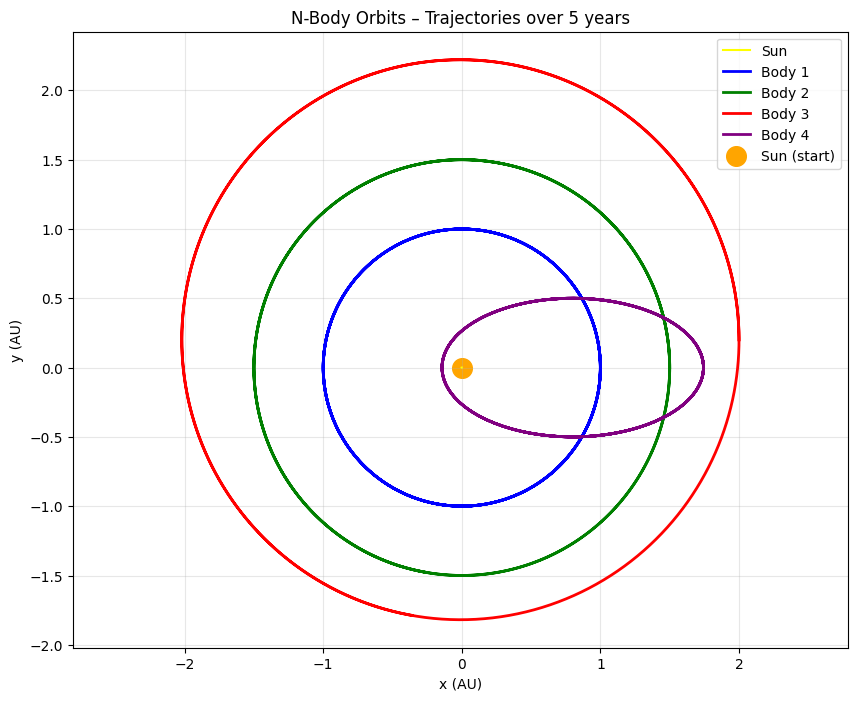

In [5]:
plt.figure(figsize=(10, 8))
colors = ['yellow', 'blue', 'green', 'red', 'purple']

for i in range(n_bodies):
    plt.plot(positions_over_time[:, i, 0], positions_over_time[:, i, 1],
             color=colors[i], lw=1.5 if i==0 else 2, label=f'Body {i}' if i>0 else 'Sun')

plt.scatter([0], [0], color='orange', s=200, label='Sun (start)')
plt.title('N-Body Orbits – Trajectories over 5 years')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

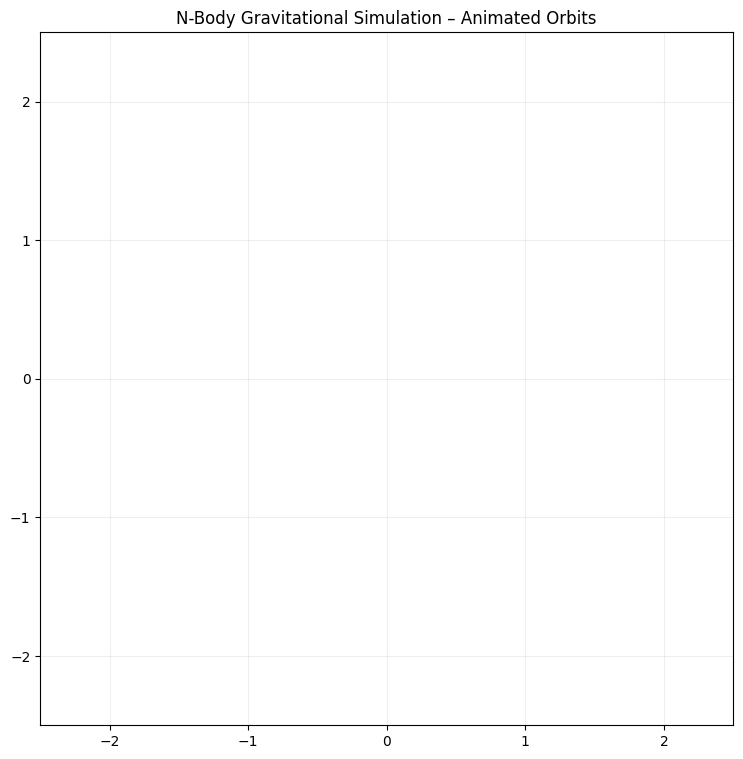

In [6]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)

# Trails (fading lines)
trails = [ax.plot([], [], '-', lw=1.2, alpha=0.6)[0] for _ in range(n_bodies)]
points = [ax.plot([], [], 'o', ms=10 if i==0 else 6, color=colors[i])[0] for i in range(n_bodies)]

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12)

def init():
    for trail, point in zip(trails, points):
        trail.set_data([], [])
        point.set_data([], [])
    time_text.set_text('')
    return trails + points + [time_text]

trail_history = [[] for _ in range(n_bodies)]

def animate(frame):
    for i in range(n_bodies):
        x, y = positions_over_time[frame, i, 0], positions_over_time[frame, i, 1]
        
        # Update point
        points[i].set_data([x], [y])
        
        # Append to trail
        trail_history[i].append((x, y))
        if len(trail_history[i]) > 100:
            trail_history[i].pop(0)
        
        trail_x, trail_y = zip(*trail_history[i])
        trails[i].set_data(trail_x, trail_y)
    
    time_text.set_text(f'Year = {t[frame]:.2f}')
    return trails + points + [time_text]

ani = FuncAnimation(fig, animate, frames=len(t), init_func=init, interval=20, blit=True)

plt.title('N-Body Gravitational Simulation – Animated Orbits')
plt.show()

In [7]:
ani.save('n_body_orbits.gif', writer='pillow', fps=30, dpi=100)
print("✅ GIF saved as n_body_orbits.gif")

✅ GIF saved as n_body_orbits.gif
